# Data Preprocessing and Data Analysis

#### Written by Carlos Cuevas Villarmín 

Last update: 08/02/2024

**0. Import libraries**

In [1]:
import sys, os
import pandas as pd
import numpy as np

**1. Transform Brat format into BIO.**

To do that I am going to use the following repository [https://github.com/nlplab/brat/tree/master]. In particular, the file antoconll.py

In [2]:
#Load the brat tools
sys.path.append('brat/tools')
sys.path.append('brat/server/src')

from brat.tools.anntoconll import main

In [3]:
#Read the text roots from the data folder
txt_files = ['data/'+file for file in os.listdir('data/') if file.endswith(".txt")]
#Run the brat tools on the text files to generate the conll files
main(['-']+txt_files) #The - is a dummy argument to make the brat tools work


Eliminate Textbound(start=562, end=565, type='total-participants', text='240') due to overlap with Textbound(start=562, end=565, type='total-participants', text='240')
Eliminate Textbound(start=562, end=565, type='total-participants', text='240') due to overlap with Textbound(start=562, end=565, type='total-participants', text='240')


**2. Read the documents and create the DataFrame**

In [2]:
#Auxiliar function to read all type of data documents
def ReadFiles(folder_path):
    '''
    Function that read the content of data files from a folder
    Args:
        folder_path: The path to the folder containing the data files
    Returns:
        A dictionary with the content of the id of the files, the conll, txt and ann files content
    '''
    txt_files = [file for file in os.listdir(folder_path) if file.endswith(".txt")]
    ann_files = [file for file in os.listdir(folder_path) if file.endswith(".ann")]
    conll_files = [file for file in os.listdir(folder_path) if file.endswith(".conll")]

    files = {'id': [], 'conll': [], 'txt': [], 'ann': [], 'id_2': [], 'id_3': []}

    for file in ann_files:
        files['id'].append(file.split('.')[0])
        file_path = os.path.join(folder_path, file)
        with open(file_path, "r") as f:
            files['ann'].append(f.read())
    
    for file in txt_files:
        file_path = os.path.join(folder_path, file)
        with open(file_path, "r") as f:
            files['txt'].append(f.read())

    for file in conll_files:
        file_path = os.path.join(folder_path, file)
        with open(file_path, "r") as f:
            files['conll'].append(f.read())

    
    return files

Now, once the data has been transformed into BIO format in the .conll files the following step is to read these files and create a DataFrame with the information of the files adding the File_ID the information belongs to. Additionally, to add later a column with the Sentence_ID at each file the blank lines of the files will be set to NaN to consider it as a separator.

In [4]:

data = {'File_ID': [], 'Entity': [], 'Start': [], 'End': [], 'Words': []}

#Read the root of .conll files
conll_files = [file for file in os.listdir('./data/') if file.endswith(".conll")]

for file in conll_files:
    #Read the files
    file_path = os.path.join('./data/', file)
    with open(file_path, "r") as f:
        lines = f.readlines()

        #Add the info of each line of 'file' to the data dict
        for line in lines:
            data['File_ID'].append(file.split('.')[0])
            line = line.split()
            if len(line)>0:
                data['Entity'].append(line[0])
                data['Start'].append(line[1])
                data['End'].append(line[2])
                data['Words'].append(line[3])
            else: #For blank lines
                data['Entity'].append(np.nan)
                data['Start'].append(np.nan)
                data['End'].append(np.nan)
                data['Words'].append(np.nan)

#Transform data dict into DataFrame
data_df = pd.DataFrame(data)

#Report the shape and an overview of the DataFrame
print(f"Length of the data: {data_df.shape}")
data_df

Length of the data: (399068, 5)


,File_ID,Entity,Start,End,Words
0,24599578,O,0,1,A
1,24599578,O,2,13,multicenter
2,24599578,O,14,24,randomized
3,24599578,O,25,30,trial
4,24599578,O,31,33,of
...,...,...,...,...,...
399063,17363187,O,1760,1765,local
399064,17363187,O,1766,1769,and
399065,17363187,O,1770,1777,overall
399066,17363187,O,1778,1785,relapse


In order to illustrate the effect of blank lines, print the first 30 lines of the DataFrame in order to see one of these separator rows.

In [5]:
data_df[0:30]

,File_ID,Entity,Start,End,Words
0,24599578,O,0,1,A
1,24599578,O,2,13,multicenter
2,24599578,O,14,24,randomized
3,24599578,O,25,30,trial
4,24599578,O,31,33,of
5,24599578,O,34,37,the
6,24599578,O,38,45,effects
7,24599578,O,46,48,of
8,24599578,B-intervention,49,57,exercise
9,24599578,O,58,62,dose


Each sentence is separated by a blank line. In row 22 of the DataFrame, makes evident that in such cases, all the values are NaN. This structure provides the opportunity to add a sentenceID to each word, allowing us to identify all the words belonging to the same sentence.

**3. Clean the DataFrame**

**3.1. Add Sentece_ID column.** We will define a counter which will be the sentence where the word appears if label value or word value is not NaN. Otherwise, the Sentence_ID will be 0, i.e., in the cases of a blank line or sentence separator. Finally, I remove all rows with sentenceID=0 in order to not count the separators.

In [6]:
# Create list of sentences and counter
ls = []
counter = 1

for i in range(len(data_df)):
    # If the current line is not a sentence separator, we add the current counter to the list
    if ((pd.isna(data_df.Words[i]) == False) | (pd.isna(data_df.Entity[i]) == False)):
        ls.append(counter)
    # If the current line is a sentence separator, we add 0 to the list and increase the counter by 1
    if ((pd.isna(data_df.Words[i]) == True) & (pd.isna(data_df.Entity[i]) == True)):
        ls.append(0)
        counter += 1 
        
# We add the list to the dataframe        
data_df['Sentence_ID'] = ls

# Drop rows with data['Sentence_ID'] == 0 (blank lines)
data_df = data_df[data_df['Sentence_ID'] != 0]

In [7]:
print(f"Length of the data: {data_df.shape}")
#Visualize the data after adding the Sentence_ID and dropping the blank lines
data_df

Length of the data: (387101, 6)


,File_ID,Entity,Start,End,Words,Sentence_ID
0,24599578,O,0,1,A,1
1,24599578,O,2,13,multicenter,1
2,24599578,O,14,24,randomized,1
3,24599578,O,25,30,trial,1
4,24599578,O,31,33,of,1
...,...,...,...,...,...,...
399063,17363187,O,1760,1765,local,11968
399064,17363187,O,1766,1769,and,11968
399065,17363187,O,1770,1777,overall,11968
399066,17363187,O,1778,1785,relapse,11968


**3.2. Confirm NaN values.** Confirm that now there are not NaN values in the DataFrame.

In [8]:
#Confirm if there still exist any NaN values
data_df.isnull().sum()

File_ID        0
Entity         0
Start          0
End            0
Words          0
Sentence_ID    0
dtype: int64

**3.3. Change data types of the columns.** Change the columns to its correspondent type.

In [9]:
#Confirm the type of each column
data_df.dtypes

File_ID        object
Entity         object
Start          object
End            object
Words          object
Sentence_ID     int64
dtype: object

In [10]:
#Change the type of the column 'Start' and 'End' to int
data_df['Start']  = data_df['Start'].astype(int)
data_df['End']    = data_df['End'].astype(int)

data_df.dtypes

/tmp/ipykernel_5077/598901919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Start']  = data_df['Start'].astype(int)
/tmp/ipykernel_5077/598901919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['End']    = data_df['End'].astype(int)


File_ID        object
Entity         object
Start           int64
End             int64
Words          object
Sentence_ID     int64
dtype: object

In [11]:
#Save into csv file
data_df.to_csv('./DataProcessed/dataBIO_v2.txt', index=False)

**4. Data Analysis**

**4.1.Corpus statistics.** In this section I try to replicate the results obtained in Table 1 of the document [https://aclanthology.org/2022.wiesp-1.4.pdf] where the authors present the frequency of each entity
(sub-category) and the number of abstracts in which
each entity is found.

In [12]:
#Create a copy of the dataframe
data2_df = data_df.copy()

#Drop the rows where the Entity is O because it is not an entity of interest
data2_df = data2_df[data2_df['Entity'] != 'O']

#Count values of the column 'Entity' that start with 'B-' because it determines the number of elements per entity
Freq = pd.DataFrame(data2_df['Entity'].value_counts())

#Drop the rows where the index starts with 'I-'
Freq = Freq[Freq.index.str.startswith('I-') == False]
Freq

#Add the number of fileID uniques where each label appears
Freq['n_files'] = data2_df.groupby('Entity')['File_ID'].nunique()

#Re-order the labels to be in the same order as in the paper mentioned
Freq = Freq.reindex(['B-total-participants', 'B-intervention-participants','B-control-participants', 'B-age', 'B-eligibility', 'B-ethinicity', 'B-condition', 'B-location', 'B-intervention', 'B-control', 'B-outcome', 'B-outcome-Measure', 'B-iv-bin-abs', 'B-cv-bin-abs', 'B-iv-bin-percent', 'B-cv-bin-percent', 'B-iv-cont-mean', 'B-cv-cont-mean', 'B-iv-cont-median', 'B-cv-cont-median', 'B-iv-cont-sd', 'B-cv-cont-sd', 'B-iv-cont-q1', 'B-cv-cont-q1', 'B-iv-cont-q3', 'B-cv-cont-q3'])

#Sum the values of the column 'count'
print(f'Total number of entities: {Freq["count"].sum()}') #Article: 17739

Freq

Total number of entities: 17718


,count,n_files
Entity,,
B-total-participants,1092,846
B-intervention-participants,887,674
B-control-participants,784,647
B-age,231,210
B-eligibility,925,864
B-ethinicity,101,83
B-condition,327,321
B-location,186,168
B-intervention,1067,1011


There exist a mismatch between the frequencies obtained and the ones reported in the paper. For example, in the case of outcome we count the entity 5038 times while in the authors original report the value 5053. I will analyze in depth what is happening to clarify the methodology followed by the authors given the lack of information. The first step is to create a DataFrame with the frequency values obtained and the ones reported by the authors. Additionally, I will add columns that report the differences between the frequencies.

In [13]:
#Prepare the labels
list_B_labels = ['B-total-participants', 'B-intervention-participants','B-control-participants', 'B-age', 'B-eligibility', 'B-ethinicity', 'B-condition', 'B-location', 'B-intervention', 'B-control', 'B-outcome', 'B-outcome-Measure', 'B-iv-bin-abs', 'B-cv-bin-abs', 'B-iv-bin-percent', 'B-cv-bin-percent', 'B-iv-cont-mean', 'B-cv-cont-mean', 'B-iv-cont-median', 'B-cv-cont-median', 'B-iv-cont-sd', 'B-cv-cont-sd', 'B-iv-cont-q1', 'B-cv-cont-q1', 'B-iv-cont-q3', 'B-cv-cont-q3']
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]
list_ann_labels = [label.replace('B-', '') for label in list_B_labels]

I define a function to identify the entities where there is a mismatch between the number of .ann files the entity appears in and the number of File_ID where the entity is in the DataFrame.

In [17]:
def CountNumberFiles(files, B_label, ann_label, Freq, feedback=True):
    '''
    Function that analyzes the occurrence of the labels in the data and the frequency of the labels in the .ann files
    Args:
        files: dictionary with the ids, the text, the .ann and the .conll files
        B_label: label in the DataFrame (BIO format)
        ann_label: label in the .ann files
        Freq: DataFrame with the frequency of the labels in the data
    Returns:
        dictionary with the frequency of the label in the DataFrame, 
                        the number of files where the label is in the .ann files,
                        the number of files where the label is in the DataFrame,
                        the ids of the files where the label is in the .ann files,
                        the ids of the files where the label is in the DataFrame
    '''
    #Get the files['id'] where ann_label is in files['ann'] 
    id_mask = list(map(lambda x: ann_label in x.split(), files['ann']))
                                                                                        #To avoid to identify the label in the words tagged
    #Get the ids where id_mask is True                                                  #this way of counting appearence in the file
    from itertools import compress                                                      #should be modified
    ids_ann_files = list(compress(files['id'], id_mask))
    
    #Get the ids where B_label is in data['label']
    ids_bio_format = list(data_df['File_ID'][data_df['Entity'] == B_label].unique())

    if feedback:
        if len(ids_ann_files) != len(ids_bio_format):
            print(f"The number of files is DIFFERENT.")
            print(f"Number of files where {ann_label} is in the .ann file: {len(ids_ann_files)}")
            print(f"Number of files where {B_label} is in the data: {len(ids_bio_format)}")
        else:
            print(f"The number of files is EQUAL.")
        print(f"Frequency of {B_label} in the data: {Freq.loc[B_label]['count']}")

    return {'count': Freq.loc[B_label]['count'], 'n_ann_files': len(ids_ann_files), 'n_dataframe': len(ids_bio_format), 'ids_ann_files': ids_ann_files, 'ids_bio_format': ids_bio_format,}

In [18]:
freq_values = {}
files = ReadFiles('./data/')
for B_label, ann_label in zip(list_B_labels, list_ann_labels):
    print(f"\n{B_label} - {ann_label}")
    freq_values[ann_label] = CountNumberFiles(files, B_label, ann_label, Freq)


B-total-participants - total-participants
The number of files is DIFFERENT.
Number of files where total-participants is in the .ann file: 847
Number of files where B-total-participants is in the data: 846
Frequency of B-total-participants in the data: 1092

B-intervention-participants - intervention-participants
The number of files is EQUAL.
Frequency of B-intervention-participants in the data: 887

B-control-participants - control-participants
The number of files is EQUAL.
Frequency of B-control-participants in the data: 784

B-age - age
The number of files is DIFFERENT.
Number of files where age is in the .ann file: 213
Number of files where B-age is in the data: 210
Frequency of B-age in the data: 231

B-eligibility - eligibility
The number of files is EQUAL.
Frequency of B-eligibility in the data: 925

B-ethinicity - ethinicity
The number of files is EQUAL.
Frequency of B-ethinicity in the data: 101

B-condition - condition
The number of files is DIFFERENT.
Number of files where c

Now I add to the dictionary the authors frequency reported and create a DataFrame with all the information. Then I compute the differences between the count frequency columns and the number of files each frequency appears in.

In [19]:
#Values of the paper
tag_count_paper = [1094, 887, 784, 231, 925, 101, 327, 186, 1067, 979, 5053, 1081, 556, 465, 1376, 1148, 366, 327, 270, 247, 129, 124, 4, 4, 4, 4]
n_abstracts_paper = [847, 674, 647, 210, 864, 83, 321, 168, 1011, 949, 978, 413, 288, 258, 561, 520, 154, 154, 140, 133, 69, 67, 3, 3, 3, 3]

#Add the values of the paper to the dictionary freq_values
for i, label in enumerate(list_ann_labels):
    freq_values[label]['count_paper'] = tag_count_paper[i]
    freq_values[label]['n_abstracts_paper'] = n_abstracts_paper[i]

#Define a dataframe with the values of the dictionary freq_values
df_freq_values = pd.DataFrame(freq_values).T

#Compute the difference columns
df_freq_values['diff_count'] = df_freq_values['count'] - df_freq_values['count_paper']
df_freq_values = df_freq_values[['count', 'count_paper', 'diff_count', 'n_dataframe', 'n_abstracts_paper', 'n_ann_files']]
df_freq_values['diff_df_abstract'] = df_freq_values['n_dataframe'] - df_freq_values['n_abstracts_paper']
df_freq_values['diff_ann_abstract'] = df_freq_values['n_ann_files'] - df_freq_values['n_abstracts_paper']
df_freq_values

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
total-participants,1092,1094,-2,846,847,847,-1,0
intervention-participants,887,887,0,674,674,674,0,0
control-participants,784,784,0,647,647,647,0,0
age,231,231,0,210,210,213,0,3
eligibility,925,925,0,864,864,864,0,0
ethinicity,101,101,0,83,83,83,0,0
condition,327,327,0,321,321,322,0,1
location,186,186,0,168,168,169,0,1
intervention,1067,1067,0,1011,1011,1011,0,0
control,979,979,0,949,949,950,0,1


After seeing the results only a few of entities has been badly replicated. Let see only the cases where at least one diff column is different to zero.

In [20]:
df_freq_values.loc[(df_freq_values['diff_count'] != 0) | (df_freq_values['diff_df_abstract'] != 0) | (df_freq_values['diff_ann_abstract'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
total-participants,1092,1094,-2,846,847,847,-1,0
age,231,231,0,210,210,213,0,3
condition,327,327,0,321,321,322,0,1
location,186,186,0,168,168,169,0,1
control,979,979,0,949,949,950,0,1
outcome,5038,5053,-15,978,978,978,0,0
outcome-Measure,1077,1081,-4,413,413,413,0,0


There exist three different scenarios:
- diff_df_abstract != 0. There are missing information in some files when transforming into BIO format.
- diff_ann_abstract != 0 and diff_df_abstract = 0 the number of abstracts where entities appear is good replicated but apparently there were more abstracts where the entities are than the ones reported by the authors.
- diff_count != 0 and 0 in the other diff columns, in that cases all the files where the entities appear are good identified but partially done and there are entities of these files that has been badly transformed into BIO format.

Let see case by case what is the reason of this problem.

Case 1: diff_df_abstract !=0.

In [21]:
df_freq_values.loc[(df_freq_values['diff_df_abstract'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
total-participants,1092,1094,-2,846,847,847,-1,0


This discrepancy can be easily identified looking to the warning reported at the beginning by the brat tool:

Eliminate Textbound(start=562, end=565, type='total-participants', text='240') due to overlap with Textbound(start=562, end=565, type='total-participants', text='240')
Eliminate Textbound(start=562, end=565, type='total-participants', text='240') due to overlap with Textbound(start=562, end=565, type='total-participants', text='240')

There is one .ann file where the same word is tagged two times as total-participants and the tool used deletes it during the transformation. Let confirm printing this particular file.

In [22]:
id_tp_interest = list(set(freq_values['total-participants']['ids_ann_files']) - set(freq_values['total-participants']['ids_bio_format']))
id_tp_interest
file_path = os.path.join('./data/', id_tp_interest[0] + '.ann')
with open(file_path, "r") as f:
    print(f.read())


T1	intervention 0 10	Paclitaxel
T2	total-participants 562 565	240
T4	control-participants 673 676	178
T5	eligibility 566 606	patients treated in 6 consecutive trials
T6	intervention-participants 826 828	62
T8	cv-cont-median 1063 1073	148 months
T9	iv-cont-median 1112 1121	45 months
T10	outcome 1156 1198	Estrogen receptor (ER) status was negative
T11	cv-bin-abs 1202 1204	58
T12	cv-bin-percent 1212 1215	33%
T13	iv-bin-abs 1232 1234	40
T14	iv-bin-percent 1242 1245	65%
T15	outcome 1321 1368	objective response rates (complete and partial)
T16	cv-bin-percent 1392 1395	74%
T17	iv-bin-percent 1406 1409	82%
T18	outcome 1416 1444	median overall survival (OS)
T19	outcome 1449 1480	progression-free survival (PFS)
T20	outcome 1631 1640	median OS
T21	cv-cont-median 1651 1660	32 months
T22	iv-cont-median 1671 1680	54 months
T23	outcome 1692 1702	median PFS
T24	cv-cont-median 1713 1722	18 months
T25	iv-cont-median 1733 1742	27 months
T26	total-participants 562 565	240
T3	outcome 1024 1050	median follo

Case 2: diff_ann_abstract != 0

In [23]:
df_freq_values.loc[(df_freq_values['diff_ann_abstract'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
age,231,231,0,210,210,213,0,3
condition,327,327,0,321,321,322,0,1
location,186,186,0,168,168,169,0,1
control,979,979,0,949,949,950,0,1


In that cases we can see that the difference between entities frequency (diff_count) is well replicated. Maybe the problem is the way of counting the files where an entity appears in. Let confirm it. To do that I create a function to identify the files where the entity is absolutely bad transform into BIO and the files where the entity is partially bad transcribed.

In [24]:
def MismatchAnalysis(files, B_label, I_label, ann_label, freq_values, folder_path, mode = None, feedback = False):
    '''
    Function that analyzes the mismatch of the entities in the .ann files and the DataFrame
    Args:
        files: dictionary with the ids, the text and the .ann files
        B_label: label in the DataFrame (BIO format)
        I_label: label in the DataFrame (BIO format)
        ann_label: label in the .ann files
        freq_values: dictionary with the frequency of the label in the DataFrame
        folder_path: path where the .ann files are located
        mode: mode to use to analyze the mismatch. 
                'inside': analyze the mismatch inside the files that are common to both lists
                'None': analyze the mismatch of the files that just belong to one of the lists, i.e., bad transcriptions from one format to other
        feedback: boolean to print the information of the files
    Returns:
        dictionary with the ids where there exists a mismatch and the list where they belong (ids_ann_files or ids_bio_format)
    '''
    ids_ann_files = freq_values['ids_ann_files']
    ids_bio_format = freq_values['ids_bio_format']
    #Get the ids that just belong to one of the lists
    ids_mismatched = list(set(ids_ann_files) ^ set(ids_bio_format)) #^ is the symmetric difference
    #print(f"FileId that just belong to one of the lists: {ids_mismatched}")
    print(f"Number of fileIds where {ann_label} is not identified: {len(ids_mismatched)}")

    #Now to which list each id belongs
    #Create a dictionary with the ids and the list where they belong
    ids_dict = dict.fromkeys(ids_mismatched)
    for id in ids_dict:
        if id in ids_ann_files:
            ids_dict[id] = 'ids_ann_files'
        else:
            ids_dict[id] = 'ids_bio_format'

    #print(f"Dictionary with the ids and the list where they belong: {ids_dict}")

    #For each key in the dictionary read and print the corresponding file (in the folder ./data)
    from itertools import compress
    counter_mismatch = 0
    for id in ids_dict:
        if feedback: print(f"File: {id}")
        if ids_dict[id] == 'ids_ann_files':
            file_path = os.path.join(folder_path, id + '.ann')
            with open(file_path, "r") as f:
                lines = f.readlines()
                ids_lines_interest = list(map(lambda x: ann_label in x.split(), lines))
                if feedback: 
                    print(f"Lines of interest: {list(compress(lines, ids_lines_interest))}")
                counter_mismatch += len(list(compress(lines, ids_lines_interest)))
        if ids_dict[id] == 'ids_bio_format':
            if feedback: print(data.loc[(data['File_ID'] == id) & ((data_df['Entity'] == B_label) | (data_df['Entity'] == I_label))])
            counter_mismatch += len(data_df.loc[(data_df['File_ID'] == id) & ((data_df['Entity'] == B_label))]) #Counter based only in B- entities
        
    if feedback:
        #Choose one id in files['id'] that does not belong to ids_mismatched and print the lines of interest of this .ann file to compare 
        id_not_mismatched = list(set(files['id']) - set(ids_mismatched))[0]
        file_path = os.path.join(folder_path, id_not_mismatched + '.ann')
        with open(file_path, "r") as f:
            lines = f.readlines()
            ids_lines_interest = list(map(lambda x: ann_label in x, lines))
            print(f"Lines of interest of {id_not_mismatched} (no mismatch): {list(compress(lines, ids_lines_interest))}")

    print(f"Mismatched amount of entities: {counter_mismatch}")

    ######## Inside the files that are common to both lists ########

    if mode == 'inside':
        #Get the ids that appear in both lists
        ids_common = list(set(ids_ann_files).intersection(set(ids_bio_format)))

        common_files_mismatch_count = {'ids_common': ids_common, 'count_data': [], 'count_ann': [], 'mismatch': []}
    
        for id_file in ids_common:
            
            #Count the times B_label appears in the data in each file of ids_common
            common_files_mismatch_count['count_data'].append(data_df.loc[(data_df['File_ID'] == id_file) & (data_df['Entity'] == B_label)].shape[0])
            #Count the times ann_label appears in the .ann files in each file of ids_common 
            #Splitted in to times to avoid identifying the label in the middle of a words tagged
            aux = files['ann'][files['id'].index(id_file)].splitlines()
            counter_ann_label = 0
            for line in aux:
                splited_line = line.split()
                
                if ann_label == splited_line[1]:
                    counter_ann_label += 1
                    
            common_files_mismatch_count['count_ann'].append(counter_ann_label)
            #Count the mismatch between the times B_label appears in the data and the times ann_label appears in the .ann files in each file of ids_common
            common_files_mismatch_count['mismatch'].append(abs(common_files_mismatch_count['count_data'][-1] - common_files_mismatch_count['count_ann'][-1]))

        #Sum the values of mismatch
        total_mismatch = sum(common_files_mismatch_count['mismatch'])
        if total_mismatch != 0:
            #Get the index where the mismatch is different from 0
            keys_mismatch = [i for i, x in enumerate(common_files_mismatch_count['mismatch']) if x != 0]
            total_files_mismatch = len(keys_mismatch)
            print(f"Number of files where the occurrence in .ann files and the ocurrence in the data is not the same: {total_files_mismatch}")
            print(f"Mismatch between the number of times {B_label} appears in the data and the number of times {ann_label} appears in the .ann files: {total_mismatch}")
        else:
            print(f"The number of times {B_label} appears in the data and the number of times {ann_label} appears in the .ann files is the same.")
        
        print(f"Total entities badly transcribed: {counter_mismatch + total_mismatch}")

        #Add the keys from common_files_mismatch_count to ids_dict when mismatch is different from 0
        if total_mismatch != 0:
            for key in keys_mismatch:
                ids_dict[common_files_mismatch_count['ids_common'][key]] = 'mismatch'
    return ids_dict

In [22]:
def plotMismatchfiles(mismatch_dict, folder_path, control=False, feedback='all'):
    '''
    Function that prints the files where the mismatch is present
    Args:
        mismatch_dict: dictionary with the ids where there exists a mismatch and the list where they belong (ids_ann_files or ids_bio_format)
        folder_path: path where the .ann files are located
        control: boolean to stop the print
        feedback: type of mismatch to print
    '''
    for key in mismatch_dict.keys():
        #Read the file
        if len(mismatch_dict[key]) > 0:
            print(f"\n{key}")
            print('------------------------------------------------------------------------------------------')
            for file, id in zip(mismatch_dict[key].keys(),mismatch_dict[key].values()):
                if (feedback == 'all' or feedback == 'absolutely_mismatch') and id != 'mismatch':
                    print(f"\nFile: {file} absolutely poorly transcribed in terms of the entity")
                
                elif (feedback == 'all' or feedback == 'partially_mismatch') and id == 'mismatch':
                    print(f"\nFile: {file} partially poorly transcribed in terms of the entity")
                    
                file_path = os.path.join(folder_path, file + '.ann')
                with open(file_path, "r") as f:
                    print(f.read())

                if id == 'mismatch': print(data_df.loc[(data_df['File_ID'] == file) & ((data_df['Entity'] == 'B-'+ key) | (data_df['Entity'] == 'I-'+ key))])
                    
                #Input to stop the print by the user and option to break the loop
                if control:
                    input_ = input('Do you want to stop the print? (y/n): ')
                    if input_ == 'y':
                        break
        if control and input_ == 'y':
            break

In [23]:
#Get the index of the rows of interest
index_rows = df_freq_values.loc[(df_freq_values['diff_ann_abstract'] != 0)].index #Entity names
#Transform into B-labels and I-labels format
list_B_labels = ['B-' + label for label in index_rows]
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]

mismatch_dict = {}
for B_label, I_label, ann_label in zip(list_B_labels, list_I_labels, index_rows):
    print('------------------------------------------------------------------------------------------')
    print(f"{B_label} - {I_label} - {ann_label}")
    print('------------------------------------------------------------------------------------------')
    mismatch_dict[ann_label] = MismatchAnalysis(files, B_label, I_label, ann_label, freq_values[ann_label], folder_path = './data/', feedback = False)

------------------------------------------------------------------------------------------
B-age - I-age - age
------------------------------------------------------------------------------------------
Number of fileIds where age is not identified: 3
Mismatched amount of entities: 3
------------------------------------------------------------------------------------------
B-condition - I-condition - condition
------------------------------------------------------------------------------------------
Number of fileIds where condition is not identified: 1
Mismatched amount of entities: 2
------------------------------------------------------------------------------------------
B-location - I-location - location
------------------------------------------------------------------------------------------
Number of fileIds where location is not identified: 1
Mismatched amount of entities: 1
------------------------------------------------------------------------------------------
B-control - I

In this case, I just analyze the occurrence in the .ann files that are not transformed into BIO because with the good transformed files the frequency of the entities is good replicated. Once we have the files that make diff_ann_abstract != 0 it is time to print the files to find the problem.

In [24]:
plotMismatchfiles(mismatch_dict, folder_path='./data/', control=False, feedback='all')


age
------------------------------------------------------------------------------------------

File: 15245618 absolutely poorly transcribed in terms of the entity
T4	total-participants 316 339	One hundred ninety-four
T5	eligibility 340 414	patients with histologically proven primary node-negative breast carcinoma
T7	intervention-participants 474 476	98
T8	control-participants 524 526	96
T9	outcome 584 592	relapses
T10	outcome 600 606	deaths
T11	outcome 626 663	relapse-free survival rate at 7 years
T12	iv-bin-percent 689 692	93%
T13	cv-bin-percent 701 704	81%
T14	outcome 1105 1137	overall survival rate at 7 years
T15	outcome 777 793	stage T2 disease
T16	iv-bin-percent 795 799	100%
T17	cv-bin-percent 827 830	64%
T18	outcome 863 900	younger and/or premenopausal patients
T19	iv-bin-percent 933 937	100%
T20	cv-bin-percent 963 966	81%
T21	outcome 1001 1032	patients > or = 50 years of age
T22	iv-bin-percent 1034 1037	90%
T23	cv-bin-percent 1063 1066	82%
T24	control 0 42	High-dose oral medro

In that case, the mismatch is caused by identifying a word in the text tagged as an entity name when counting the occurrence in .ann files. Then, it is correctly replicated and the problem is caused by the implementation used to identify the number of .ann files where the entity appears in. It identifies the files where the word associated to the entity name appears even though it appears in the text.

Case 3: diff_count != 0 and the other columns are equal to 0.

In [25]:
df_freq_values.loc[(df_freq_values['diff_ann_abstract'] == 0) & (df_freq_values['diff_df_abstract'] == 0) & (df_freq_values['diff_count'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
outcome,5038,5053,-15,978,978,978,0,0
outcome-Measure,1077,1081,-4,413,413,413,0,0


This is the real case of interest. Why having the correct number of files identified there are cases where the entity is partially recognize in the transformation? To answer this question I do the same process as before. In that case at MismatchAnalysis mode = 'inside' because the problem is inside files where the entity was recognize at least once.

In [26]:
#Get the index of the rows of interest
index_rows = df_freq_values.loc[(df_freq_values['diff_ann_abstract'] == 0) & (df_freq_values['diff_df_abstract'] == 0) & (df_freq_values['diff_count'] != 0)].index #Entity names
#Transform into B-labels and I-labels format
list_B_labels = ['B-' + label for label in index_rows]
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]

mismatch_dict = {}
for B_label, I_label, ann_label in zip(list_B_labels, list_I_labels, index_rows):
    print('------------------------------------------------------------------------------------------')
    print(f"{B_label} - {I_label} - {ann_label}")
    print('------------------------------------------------------------------------------------------')
    mismatch_dict[ann_label] = MismatchAnalysis(files, B_label, I_label, ann_label, freq_values[ann_label], folder_path = './data/', mode = 'inside', feedback = False)

------------------------------------------------------------------------------------------
B-outcome - I-outcome - outcome
------------------------------------------------------------------------------------------
Number of fileIds where outcome is not identified: 0
Mismatched amount of entities: 0


Number of files where the occurrence in .ann files and the ocurrence in the data is not the same: 14
Mismatch between the number of times B-outcome appears in the data and the number of times outcome appears in the .ann files: 15
Total entities badly transcribed: 15
------------------------------------------------------------------------------------------
B-outcome-Measure - I-outcome-Measure - outcome-Measure
------------------------------------------------------------------------------------------
Number of fileIds where outcome-Measure is not identified: 0
Mismatched amount of entities: 0
Number of files where the occurrence in .ann files and the ocurrence in the data is not the same: 4
Mismatch between the number of times B-outcome-Measure appears in the data and the number of times outcome-Measure appears in the .ann files: 4
Total entities badly transcribed: 4


See now these particular cases where some of the text tagged as outcome or outcome-Measure are not identified.

In [27]:
plotMismatchfiles(mismatch_dict, folder_path='./data/', control=False, feedback='all')


outcome
------------------------------------------------------------------------------------------

File: 27018693 partially poorly transcribed in terms of the entity
T2	control 74 98	General Anesthesia Alone
T3	eligibility 466 507	patients undergoing breast reconstruction
T7	total-participants 870 872	74
T8	intervention-participants 935 937	35
T9	control-participants 965 967	39
T13	iv-cont-mean 1269 1272	109
T15	iv-cont-mean 1379 1382	3.0
T16	cv-cont-mean 1390 1393	4.6
T17	outcome 1371 1377	0 to 1
T18	outcome 1406 1412	1 to 3
T19	iv-cont-mean 1414 1417	2.0
T20	cv-cont-mean 1425 1428	3.2
T21	outcome 1445 1451	3 to 6
T22	iv-cont-mean 1453 1456	1.9
T23	cv-cont-mean 1464 1467	2.7
T24	iv-cont-mean 1560 1563	0.7
T25	cv-cont-mean 1571 1574	2.1
T1	intervention 47 66	Paravertebral Block
T10	cv-cont-mean 1280 1309	246 fentanyl equivalent units
T11	outcome 1356 1370	pain scores at
T12	outcome 1537 1558	antiemetic medication
T4	outcome 1151 1194	opioid intraoperatively and postoperatively

     

In that cases the difference in the values is causes by joinning two consecutive texts tagged with the same entity. The authors consider it two independent texts and it is translated into two B-entity_name in the .conll file associated and in my case it will be only one B-entity_name. It make more sense to consider all one text tagged together than in two ways so the approach done can be assumed as correct.

Once the results of our DataFrame has been analyzed and proved to be correct it is time to prepare the data for the model.

**4.2. Length per sentence and per file analysis.** As the models have a max_length parameter it is important to know this parameter in our dataset. We can do two different approaches:

1. Consider each abstract as a unique entry. Therefore, it will provide more context. However, sometimes the size of the text will surpass max_length parameter of the model, for example the 512 tokens allowed by BERT-based models, and the text must be truncated arbitrarily.

2. Consider each sentence inside the text as an independent entry to the model. The disadvantage in this scenario is that the training time will be higher. On the other hand, the advantage is that the full information of the text can be considered, but the sentences are not related.

**4.2.1. Length analysis per sentence.** The length can be obtained counting the number of times each Sentence_ID appears in the DataFrame.

In [31]:
# Metrics for the length of the sentences in the data
data_df.Sentence_ID.value_counts().describe(include='all')

count    11968.000000
mean        32.344669
std         19.557508
min          2.000000
25%         18.000000
50%         28.000000
75%         42.000000
max        222.000000
Name: count, dtype: float64

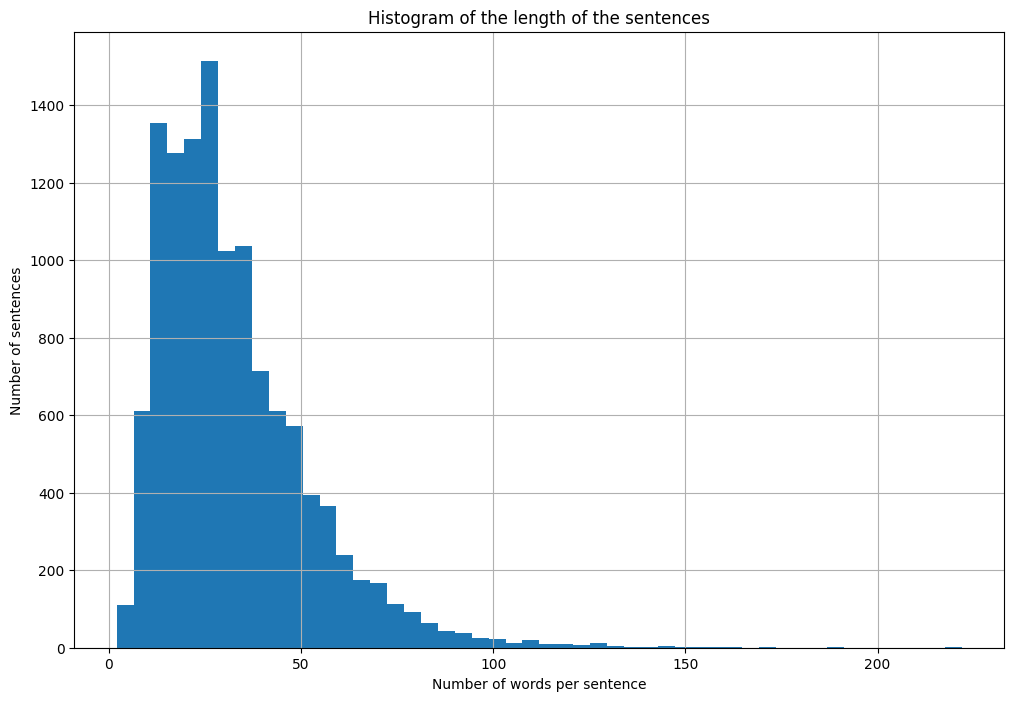

In [33]:
#Plot a histogram of the length of the sentences
import matplotlib.pyplot as plt
data_df.Sentence_ID.value_counts().hist(bins=50, figsize=(12, 8))
plt.title('Histogram of the length of the sentences')
plt.xlabel('Number of words per sentence')
plt.ylabel('Number of sentences')
plt.show()

We can see that the maximum number of tokens that appear in a sentence is 222 but the distribution of the sentence length has a mean around 32.

**4.2.2. Length analysis per text.** In that case the number of tokens per file can be obtain counting the times each File_ID appears in the DataFrame.

In [34]:
# Metrics for the length of the text in the data
data_df.File_ID.value_counts().describe(include='all')

count    1011.000000
mean      382.889219
std        93.521214
min       185.000000
25%       329.000000
50%       372.000000
75%       415.000000
max       986.000000
Name: count, dtype: float64

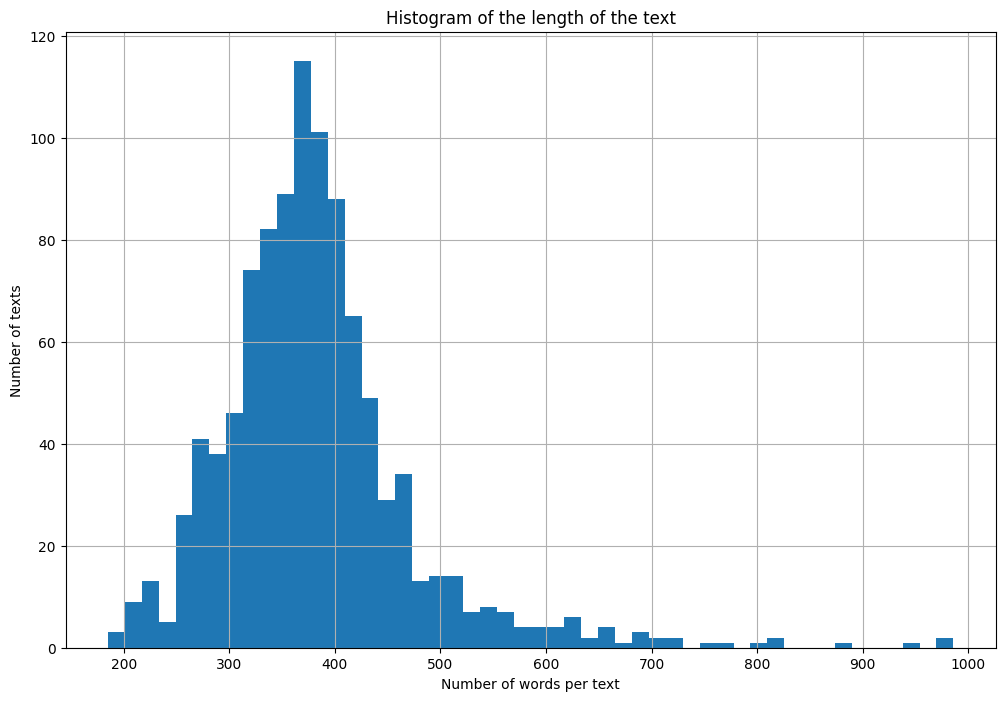

In [44]:
#Plot a histogram of the length of the sentences
import matplotlib.pyplot as plt
data_df.File_ID.value_counts().hist(bins=50, figsize=(12, 8))
plt.title('Histogram of the length of the text')
plt.xlabel('Number of words per text')
plt.ylabel('Number of texts')
plt.show()

Let see how many files hava length greater than 512.

In [37]:
print(f"The number of files with a length greater than 512 is: {sum(data_df.File_ID.value_counts() > 512)}")

The number of files with a length greater than 512 is: 74


These files should be splitted into two different files to be able to use the full text as input of the model. In case of using this approach the modification will be done after using the particular tokenizer of the model chosen. LongFormer model does not present any problem because works with a higher max_length value. When training BioBERT with the full texts the cases where the length is greater than 512 will be truncated to this size and information will be lost. To avoid that I prepare the data and split the texts previously. (Further work)

In [49]:
#Get File_IDs with a length greater than 512
file_ids = data_df.File_ID.value_counts()
file_ids = list(file_ids[file_ids > 512].index)

**5. Split into train/validation/test set**

To do that, I will extract from the list of File_ID 80% randomly to be the files of the train set and 10% for validation and test sets. Then, I will save the dataframes as dataBIO_train.txt, dataBIO_val.txt and dataBIO_test.txt

In [52]:
#Create a list of the fileID uniques
File_ID = data_df['File_ID'].unique()
File_ID

array(['24599578', '25275577', '12926095', ..., '26566950', '28084150',
       '17363187'], dtype=object)

In [54]:
#Choose randomly 80% of the File_ID indexes
import random
random.seed(42)
train = random.sample(list(File_ID), int(len(File_ID)*0.8))

#Create a list of the fileID indexes that are not in the train list
no_train = list(set(File_ID) - set(train))

#Choose randomly 50% of the File_ID indexes that are not in the train list
valid = random.sample(no_train, int(len(no_train)*0.5))

#Define test list
test = list(set(no_train) - set(valid))

#Comprobation of the length of the lists
print(f'Length of train set: {len(train)}') 
print(f'Length of validation set: {len(valid)}')
print(f'Length of test set: {len(test)}')
print(f'Total length: {len(train) + len(valid) + len(test)}')


Length of train set: 808
Length of validation set: 101
Length of test set: 102
Total length: 1011


In [57]:
#Generate the dataBIO dataframes for each set
train_df = data_df[data_df['File_ID'].isin(train)]
valid_df = data_df[data_df['File_ID'].isin(valid)]
test_df = data_df[data_df['File_ID'].isin(test)]

#Comprobation of the length of the dataframes
train_df['File_ID'].nunique(), valid_df['File_ID'].nunique(), test_df['File_ID'].nunique()

(808, 101, 102)

In [58]:
train_df

,File_ID,Entity,Start,End,Words,Sentence_ID
0,24599578,O,0,1,A,1
1,24599578,O,2,13,multicenter,1
2,24599578,O,14,24,randomized,1
3,24599578,O,25,30,trial,1
4,24599578,O,31,33,of,1
...,...,...,...,...,...,...
399063,17363187,O,1760,1765,local,11968
399064,17363187,O,1766,1769,and,11968
399065,17363187,O,1770,1777,overall,11968
399066,17363187,O,1778,1785,relapse,11968


**6. Analysis of the sets**

Now, we can compute how many elements each entity has in each of the sets.

In [61]:
Freq['train_set'] = train_df[train_df['Entity'] != 'O'].value_counts('Entity')
Freq['valid_set'] = valid_df[valid_df['Entity'] != 'O'].value_counts('Entity')
Freq['test_set'] = test_df[test_df['Entity'] != 'O'].value_counts('Entity')

Freq

,count,n_files,train_set,valid_set,test_set
Entity,,,,,
B-total-participants,1092,846,867,114,111
B-intervention-participants,887,674,714,77,96
B-control-participants,784,647,622,79,83
B-age,231,210,187,21,23
B-eligibility,925,864,732,100,93
B-ethinicity,101,83,73,19,9
B-condition,327,321,269,30,28
B-location,186,168,148,22,16
B-intervention,1067,1011,855,105,107


For each set I will define a dataFrame to know how many tokens are per field, how many sentences, ratios, etc.

In [69]:
def GenerateInfoDF(df):
    '''
    Function that generates a DataFrame with different metrics to analyse the similarities between samples in the sets.
    Args:
        df: DataFrame with columns File_ID, Entity, Start, End, Words, Sentence_ID
    Returns:
        df_info: DataFrame with the metrics computed
    '''
    df_info =pd.DataFrame(df.groupby('File_ID')['Sentence_ID'].nunique())
    #Rename the column
    df_info = df_info.rename(columns={'Sentence_ID':'n_sentences'})
    df_info['n_tokens'] = df.groupby('File_ID')['Words'].count()
    #Add the number of entities of interest in BIO format (keep B- and I-, drop O)
    df_info['n_entities'] = df.groupby('File_ID')['Entity'].count()-df.groupby('File_ID')['Entity'].apply(lambda x: x.str.startswith('O').sum())
    #Add the number of unique entities of interest in BIO format (keep B-, drop O and I- are the same entity as B-)
    df_info['n_unique_entities'] = df.groupby('File_ID')['Entity'].apply(lambda x: x[x.str.startswith('B-')].nunique())
    #Add the ratio of entities (B- and I-) per sentence
    df_info['ratio_entities_sentence'] = df_info['n_entities'] / df_info['n_sentences']
    #Add the ratio of entities (B- and I-) per token
    df_info['ratio_entities_token'] = df_info['n_entities'] / df_info['n_tokens']

    return df_info


In [70]:
train_info = GenerateInfoDF(train_df)
valid_info = GenerateInfoDF(valid_df)
test_info = GenerateInfoDF(test_df)

In [71]:
print('Train set information per file')
train_info

Train set information per file


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
File_ID,,,,,,
10459028,15,300,43,13,2.866667,0.143333
10547391,13,438,80,8,6.153846,0.182648
11283119,10,312,26,5,2.600000,0.083333
12374678,11,343,53,6,4.818182,0.154519
12377957,14,436,86,11,6.142857,0.197248
...,...,...,...,...,...,...
9060533,15,427,67,11,4.466667,0.156909
9363868,11,409,43,12,3.909091,0.105134
9626201,14,384,51,7,3.642857,0.132812


In [72]:
print('Train set statistics')
train_info.describe()

Train set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000
mean,12.861386,382.711634,59.731436,9.435644,4.775913,0.157017
std,2.868121,91.856751,25.419863,2.655021,2.074610,0.057497
min,6.000000,185.000000,10.000000,3.000000,0.769231,0.028818
25%,11.000000,328.000000,40.000000,7.000000,3.228632,0.115236
50%,13.000000,372.000000,56.000000,10.000000,4.464103,0.151668
75%,15.000000,414.000000,74.000000,11.000000,5.928571,0.191351
max,23.000000,980.000000,198.000000,17.000000,14.500000,0.375000


In [73]:
print('Validation set information per file')
valid_info

Validation set information per file


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
File_ID,,,,,,
12393819,11,344,74,11,6.727273,0.215116
15014181,12,354,51,11,4.250000,0.144068
15117982,10,418,59,10,5.900000,0.141148
15179836,9,190,32,11,3.555556,0.168421
15341559,11,371,60,6,5.454545,0.161725
...,...,...,...,...,...,...
32901672,14,327,92,11,6.571429,0.281346
32954927,13,421,75,8,5.769231,0.178147
32965030,10,281,48,11,4.800000,0.170819


In [74]:
print('Validation set statistics')
valid_info.describe()

Validation set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,12.673267,378.247525,57.762376,9.237624,4.742388,0.153911
std,3.355917,94.998990,25.140465,3.082689,2.101911,0.058195
min,6.000000,190.000000,15.000000,3.000000,1.153846,0.039788
25%,11.000000,327.000000,37.000000,7.000000,3.307692,0.113744
50%,12.000000,372.000000,59.000000,9.000000,4.692308,0.155056
75%,15.000000,418.000000,72.000000,11.000000,5.727273,0.190616
max,26.000000,819.000000,126.000000,20.000000,11.428571,0.316940


In [75]:
print('Test set information per file')
test_info

Test set information per file


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
File_ID,,,,,,
11136837,15,500,47,8,3.133333,0.094000
12621740,12,268,41,17,3.416667,0.152985
12721239,15,372,49,10,3.266667,0.131720
15154664,8,254,55,8,6.875000,0.216535
15254052,13,439,110,12,8.461538,0.250569
...,...,...,...,...,...,...
31962198,10,392,93,11,9.300000,0.237245
32036471,10,300,115,11,11.500000,0.383333
32416251,18,484,95,9,5.277778,0.196281


In [76]:
print('Test set statistics')
test_info.describe()

Test set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,12.803922,388.892157,57.313725,9.441176,4.631084,0.149600
std,3.137254,105.122645,24.111121,2.697904,2.044817,0.057312
min,8.000000,214.000000,14.000000,5.000000,0.777778,0.027290
25%,10.000000,335.000000,41.000000,7.000000,3.155556,0.100761
50%,12.500000,372.500000,54.000000,10.000000,4.251748,0.145789
75%,15.000000,411.500000,70.250000,11.000000,5.794444,0.184872
max,24.000000,986.000000,145.000000,17.000000,12.500000,0.383333


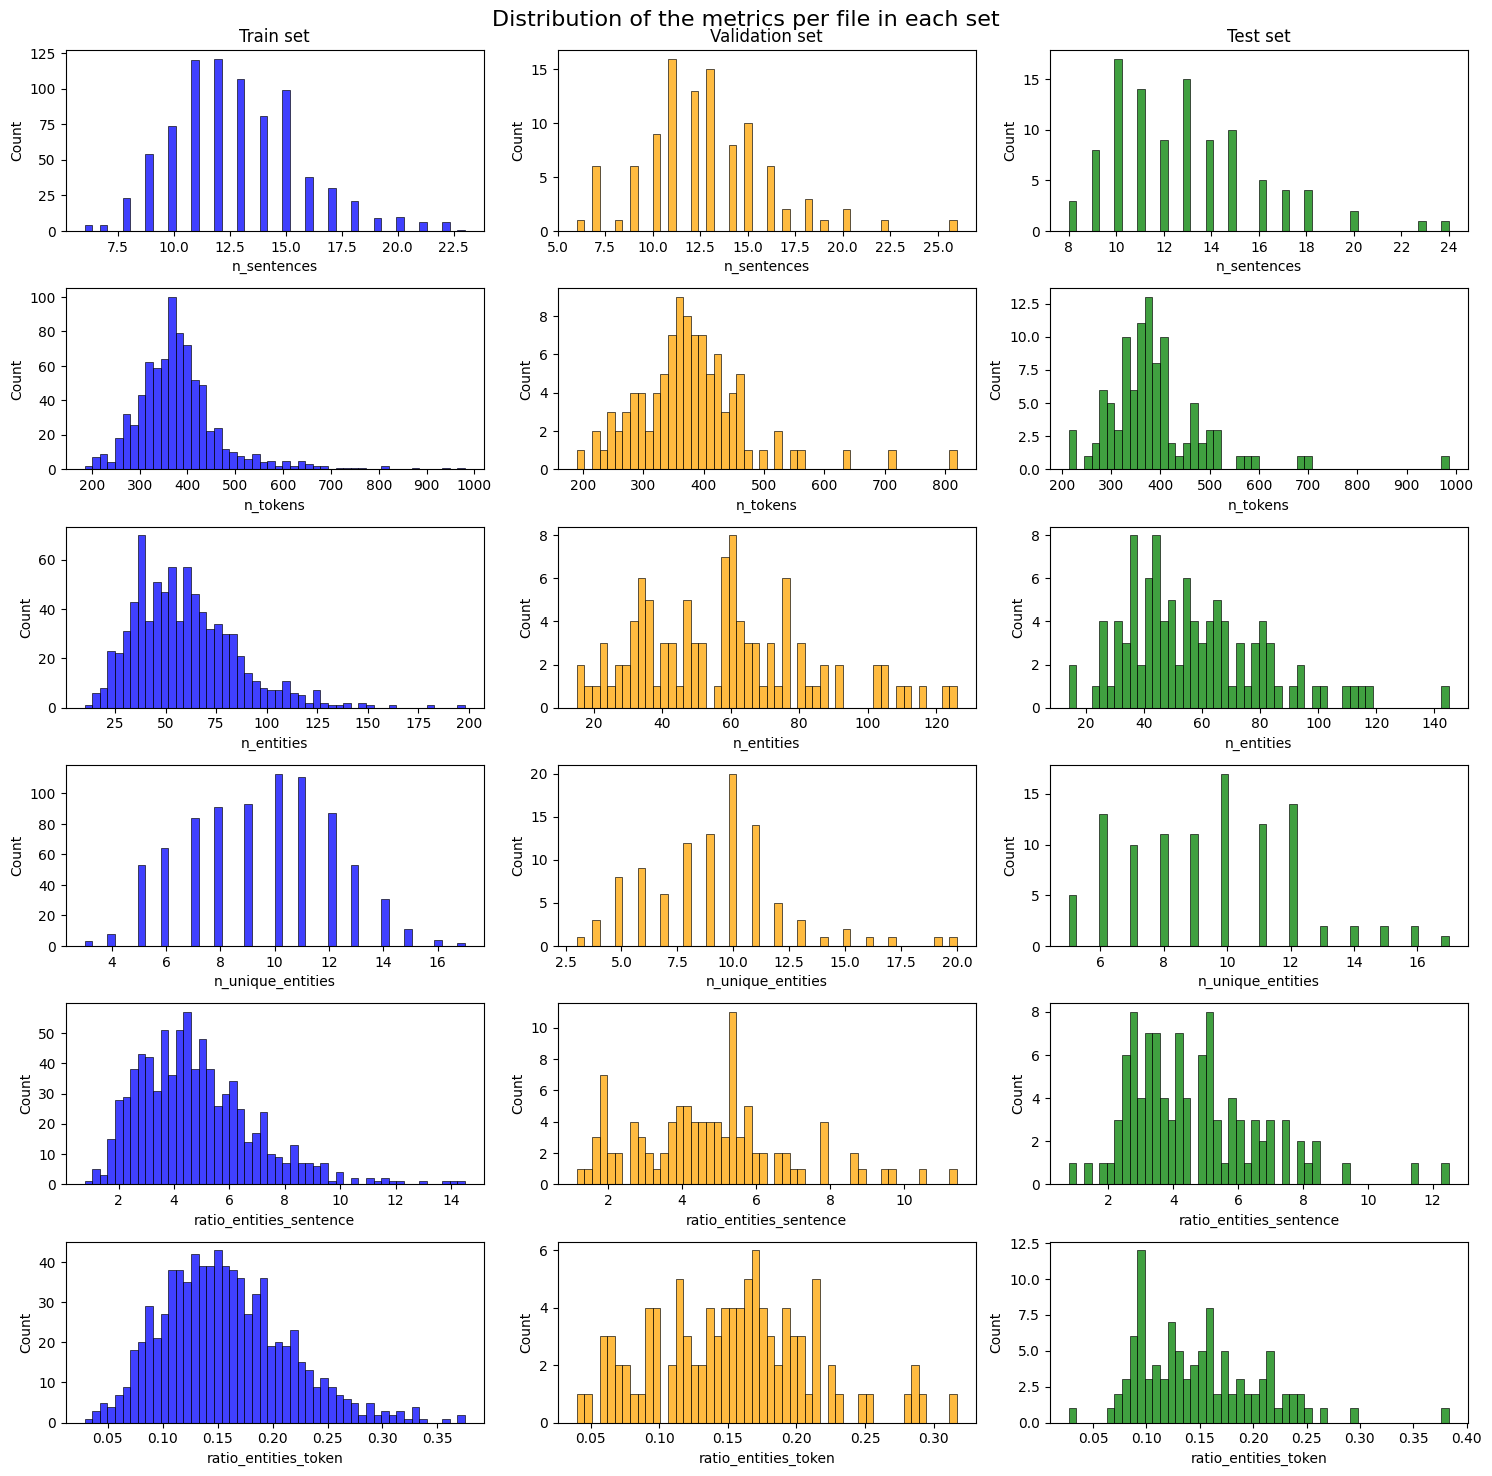

In [77]:
#Generate a plot with subfigures where each row is a column of the dataframe train_info and each column is a set (train, valid, test) and plot a histogram
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(6, 3, figsize=(15, 15))
fig.suptitle('Distribution of the metrics per file in each set', fontsize=16)

sns.histplot(ax=axes[0, 0], data=train_info, x='n_sentences', bins=50, color='blue')
axes[0, 0].set_title('Train set')
sns.histplot(ax=axes[0, 1], data=valid_info, x='n_sentences', bins=50, color='orange')
axes[0, 1].set_title('Validation set')
sns.histplot(ax=axes[0, 2], data=test_info, x='n_sentences', bins=50, color='green')
axes[0, 2].set_title('Test set')

sns.histplot(ax=axes[1, 0], data=train_info, x='n_tokens', bins=50, color='blue')   
sns.histplot(ax=axes[1, 1], data=valid_info, x='n_tokens', bins=50, color='orange')
sns.histplot(ax=axes[1, 2], data=test_info, x='n_tokens', bins=50, color='green')

sns.histplot(ax=axes[2, 0], data=train_info, x='n_entities', bins=50, color='blue')
sns.histplot(ax=axes[2, 1], data=valid_info, x='n_entities', bins=50, color='orange')
sns.histplot(ax=axes[2, 2], data=test_info, x='n_entities', bins=50, color='green')

sns.histplot(ax=axes[3, 0], data=train_info, x='n_unique_entities', bins=50, color='blue')
sns.histplot(ax=axes[3, 1], data=valid_info, x='n_unique_entities', bins=50, color='orange')
sns.histplot(ax=axes[3, 2], data=test_info, x='n_unique_entities', bins=50, color='green')

sns.histplot(ax=axes[4, 0], data=train_info, x='ratio_entities_sentence', bins=50, color='blue')
sns.histplot(ax=axes[4, 1], data=valid_info, x='ratio_entities_sentence', bins=50, color='orange')
sns.histplot(ax=axes[4, 2], data=test_info, x='ratio_entities_sentence', bins=50, color='green')

sns.histplot(ax=axes[5, 0], data=train_info, x='ratio_entities_token', bins=50, color='blue')
sns.histplot(ax=axes[5, 1], data=valid_info, x='ratio_entities_token', bins=50, color='orange')
sns.histplot(ax=axes[5, 2], data=test_info, x='ratio_entities_token', bins=50, color='green')

#Define the distance between the subplots
plt.tight_layout(pad=1.0)

plt.show()





We can conclude that the distribution of the considered metrics are similar in the validation and test set in all the cases and more different to the train set results. However, this is not necessarely a problem and it will be probably caused by the considerably higher number of files in the set.

**7. Prepare data to pass it to the model**

Depending on the approach chosen the model will receive an input per text or an input per sentence of each text.

In [79]:
def PreprocessingData(df, entry_param = 'complete'):
    '''
    Function that preprocesses the data to have a dataframe with the sentences and the labels of the entities in BIO format.
    Args:
        df: dataframe with the data
            The input dataframe must have the columns 'words', 'start', 'end', 'label' 'fileId' (if entry_param='complete') and 'sentenceID' (if entry_param = 'sentence')
        entry_param: parameter that determines if the dataframe has the complete text as a unique sample or the sentences of the text separately
    Returns:
        df_processed: dataframe with the sentences and the labels of the entities in BIO format
    '''
    if entry_param == 'complete':
        #Add a column with the sentence that each word belongs to
        df['Sentence'] = df.groupby(['File_ID'])['Words'].transform(lambda x: ' '.join(x))
        #Add a column with all the labels of the words that belong to the same sentence
        df['Entity_sentence'] = df.groupby(['File_ID'])['Entity'].transform(lambda x: ' '.join(x))

        df_processed = df[['File_ID', 'Sentence', 'Entity_sentence']].drop_duplicates().reset_index(drop=True)
    
    elif entry_param == 'sentence':
        #Add a column with the sentence that each word belongs to
        df['Sentence'] = df.groupby(['Sentence_ID'])['Words'].transform(lambda x: ' '.join(x))
        #Add a column with all the labels of the words that belong to the same sentence
        df['Entity_sentence'] = df.groupby(['Sentence_ID'])['Entity'].transform(lambda x: ' '.join(x))

        df_processed = df[['Sentence_ID', 'Sentence', 'Entity_sentence']].drop_duplicates().reset_index(drop=True)

    return df_processed

In [83]:
#Sentences considered as a unique sample
entry_param = "sentence" #complete/sentence
df_train_processed = PreprocessingData(train_df, entry_param)
df_valid_processed = PreprocessingData(valid_df, entry_param)
df_test_processed = PreprocessingData(test_df, entry_param)

/tmp/ipykernel_5077/4108244653.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'] = df.groupby(['Sentence_ID'])['Words'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_5077/4108244653.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entity_sentence'] = df.groupby(['Sentence_ID'])['Entity'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_5077/4108244653.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [82]:
print(f"Number of unique rows in train set: {train_df['Sentence_ID'].nunique()}")
print(f"Number of unique rows in train set processed: {df_train_processed['Sentence_ID'].nunique()}")
print(f"Number of unique rows in valid set: {valid_df['Sentence_ID'].nunique()}")
print(f"Number of unique rows in valid set processed: {df_valid_processed['Sentence_ID'].nunique()}")
print(f"Number of unique rows in test set: {test_df['Sentence_ID'].nunique()}")
print(f"Number of unique rows in test set processed: {df_test_processed['Sentence_ID'].nunique()}")

df_train_processed.head()


Number of unique rows in train set: 9746
Number of unique rows in train set processed: 9746
Number of unique rows in valid set: 1272
Number of unique rows in valid set processed: 1272
Number of unique rows in test set: 1291
Number of unique rows in test set processed: 1291


,Sentence_ID,Sentence,Entity_sentence
0,1,A multicenter randomized trial of the effects ...,O O O O O O O O B-intervention O O O O B-condi...
1,2,Exercise may improve psychosocial distress in ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,3,"In a multicenter trial in Canada , we randomiz...",O O O O O B-location O O O B-total-participant...
3,4,The primary endpoint was depression assessed b...,O O O O B-outcome-Measure O O O O O O O O O O ...
4,5,"Secondary endpoints were anxiety , perceived s...",O O O B-outcome-Measure O B-outcome-Measure I-...


In [84]:
#Case of complete text
df_train_processed_full = PreprocessingData(train_df)
df_valid_processed_full = PreprocessingData(valid_df)
df_test_processed_full = PreprocessingData(test_df)

/tmp/ipykernel_5077/4108244653.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'] = df.groupby(['File_ID'])['Words'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_5077/4108244653.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entity_sentence'] = df.groupby(['File_ID'])['Entity'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_5077/4108244653.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [86]:
print(f"Number of unique rows in train set: {train_df['File_ID'].nunique()}")
print(f"Number of unique rows in train set processed: {df_train_processed_full['File_ID'].nunique()}")
print(f"Number of unique rows in valid set: {valid_df['File_ID'].nunique()}")
print(f"Number of unique rows in valid set processed: {df_valid_processed_full['File_ID'].nunique()}")
print(f"Number of unique rows in test set: {test_df['File_ID'].nunique()}")
print(f"Number of unique rows in test set processed: {df_test_processed_full['File_ID'].nunique()}")

df_train_processed_full.head()

Number of unique rows in train set: 808
Number of unique rows in train set processed: 808
Number of unique rows in valid set: 101
Number of unique rows in valid set processed: 101
Number of unique rows in test set: 102
Number of unique rows in test set processed: 102


,File_ID,Sentence,Entity_sentence
0,24599578,A multicenter randomized trial of the effects ...,O O O O O O O O B-intervention O O O O B-condi...
1,12926095,Bone turnover markers and insulin - like growt...,O O O O O O O O O O O O O O O O O O O O O B-in...
2,24421054,Effect of β - glucan on drain fluid and amount...,O O B-intervention I-intervention I-interventi...
3,19281053,Managing the risk of invasive breast cancer in...,O O O O O O O O O O O O O O O O O O O O B-inte...
4,27336726,Ribociclib plus letrozole in early breast canc...,B-intervention I-intervention I-intervention O...


**7. Save the BIO dataFrames for each set and train/val/test sets processed**

In [101]:
train_df.to_csv('./DataProcessed/trainBIO.txt', sep=' ', index=False)
valid_df.to_csv('./DataProcessed/validBIO.txt', sep=' ', index=False)
test_df.to_csv('./DataProcessed/testBIO.txt', sep=' ', index=False)

In [102]:
df_valid_processed_full.to_csv('./DataProcessed/valid_full_text.txt', sep=' ', index=False)
df_train_processed_full.to_csv('./DataProcessed/train_full_text.txt', sep=' ', index=False)
df_test_processed_full.to_csv('./DataProcessed/test_full_text.txt', sep=' ', index=False)

df_valid_processed.to_csv('./DataProcessed/valid_sentences.txt', sep=' ', index=False)
df_train_processed.to_csv('./DataProcessed/train_sentences.txt', sep=' ', index=False)
df_test_processed.to_csv('./DataProcessed/test_sentences.txt', sep=' ', index=False)

**8. Create the DataSet.**

In [1]:
#Load data from csv files

path_train = "./DataProcessed/train_full_text.txt"
path_valid = "./DataProcessed/valid_full_text.txt"
path_test  = "./DataProcessed/test_full_text.txt"

import pandas as pd

def load_data(path):
    #Read csv file specifying that the first row is the header
    df = pd.read_csv(path, sep=" ", header=0)
    return df

train = load_data(path_train)
valid = load_data(path_valid)
test  = load_data(path_test)

I split the elements of each sentence (or text) and save it in a list.

In [2]:
def SplitData(df):
    '''
    Function that splits the data into words and labels
    Args:   
        df: pandas dataframe
    Returns:
        words: list of lists of words
        words_labels: list of lists of labels
    '''
    words   = [sentence.split() for sentence in df['Sentence']]
    words_labels = [entity.split() for entity in df['Entity_sentence']]
    print("Number of sentences: ", len(words))
    print("Number of labels: ", len(words_labels))

    return words, words_labels

In [3]:
words_train, words_labels_train = SplitData(train)
words_valid, words_labels_valid = SplitData(valid)
words_test, words_labels_test = SplitData(test)

Number of sentences:  808
Number of labels:  808
Number of sentences:  101
Number of labels:  101
Number of sentences:  102
Number of labels:  102


Map the words_labels into int values.

In [5]:
#Define the tags
data = pd.read_csv("./DataProcessed/dataBIO_v2.txt", sep=",", header=None, names = ['File_ID', 'Entity', 'Start', 'End', 'Words', 'Sentence_ID']) 
tag_values = list(set(data["Entity"].values))

tag2idx = {t: i for i, t in enumerate(tag_values)}
idx2tag = {i: t for i, t in enumerate(tag_values)}

print(tag2idx)
print(idx2tag)

{'B-iv-cont-median': 0, 'I-cv-bin-abs': 1, 'B-cv-bin-percent': 2, 'B-iv-cont-q3': 3, 'I-cv-cont-mean': 4, 'B-cv-cont-sd': 5, 'B-ethinicity': 6, 'I-cv-cont-q3': 7, 'I-control-participants': 8, 'O': 9, 'B-total-participants': 10, 'I-outcome-Measure': 11, 'B-cv-cont-mean': 12, 'I-iv-cont-q3': 13, 'B-intervention-participants': 14, 'B-outcome-Measure': 15, 'B-eligibility': 16, 'B-location': 17, 'I-iv-cont-median': 18, 'B-condition': 19, 'B-iv-cont-q1': 20, 'B-iv-cont-mean': 21, 'I-age': 22, 'B-intervention': 23, 'I-total-participants': 24, 'I-eligibility': 25, 'B-iv-bin-percent': 26, 'B-control-participants': 27, 'I-cv-cont-median': 28, 'B-cv-cont-median': 29, 'I-iv-bin-percent': 30, 'B-cv-bin-abs': 31, 'B-control': 32, 'B-cv-cont-q3': 33, 'I-location': 34, 'I-iv-cont-sd': 35, 'I-cv-cont-sd': 36, 'I-outcome': 37, 'I-iv-cont-mean': 38, 'Entity': 39, 'I-condition': 40, 'B-iv-bin-abs': 41, 'B-age': 42, 'I-control': 43, 'B-cv-cont-q1': 44, 'I-intervention-participants': 45, 'I-intervention': 4

/tmp/ipykernel_3124/2104466204.py:2: DtypeWarning: Columns (0,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./DataProcessed/dataBIO_v2.txt", sep=",", header=None, names = ['File_ID', 'Entity', 'Start', 'End', 'Words', 'Sentence_ID'])


In [6]:
#Map the labels to the tags
def MapLabels(words_labels, tag2idx):
    '''
    Function that maps the labels to the tags
    Args:
        words_labels: list of lists of labels
        tag2idx: dictionary that maps the labels to the tags
    Returns:
        labels: list of lists of tags
    '''
    labels = [[tag2idx.get(l) for l in lab] for lab in words_labels]
    return labels

In [7]:
labels_train = MapLabels(words_labels_train, tag2idx)
labels_valid = MapLabels(words_labels_valid, tag2idx)
labels_test  = MapLabels(words_labels_test, tag2idx)

In [4]:
#Create a dataset for each set
from datasets import Dataset

def CreateDataset(words, words_labels):
    '''
    Function that creates a dataset with id, words and labels
    Args:
        words: list of lists of words
        words_labels: list of lists of labels
    Returns:
        dataset: dataset with id, words and labels
    '''
    dataset = Dataset.from_dict({"id": range(len(words)), "tokens": words, "ner_tags": words_labels})
    return dataset


In [5]:
train_dataset = CreateDataset(words_train, words_labels_train)
valid_dataset = CreateDataset(words_valid, words_labels_valid)
test_dataset  = CreateDataset(words_test, words_labels_test)


In [6]:
dataset = {"train": train_dataset, "valid": valid_dataset, "test": test_dataset}

#Transform dataset dict into a dataset object
from datasets import DatasetDict

dataset = DatasetDict(dataset)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 808
    })
    valid: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 101
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 102
    })
})

In [7]:
#Save the dataset
dataset.save_to_disk("./DataProcessed/dataset")

Saving the dataset (0/1 shards):   0%|          | 0/808 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/101 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/102 [00:00<?, ? examples/s]

**9. Push the Dataset to HuggingFace.**

In [8]:
#huggingface-cli login (in terminal)
dataset.push_to_hub("cuevascarlos/PICO-breast-cancer")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/543 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/cuevascarlos/PICO-breast-cancer/commit/00472d179e0f7e538581a10d84f7627dbdf9cb01', commit_message='Upload dataset', commit_description='', oid='00472d179e0f7e538581a10d84f7627dbdf9cb01', pr_url=None, pr_revision=None, pr_num=None)